In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from scipy import stats
import math
from pymoo.indicators.hv import HV
import time


In [30]:
#Reference to the code in this cell: https://github.com/sharma-n/global_optimization/blob/master/7.%20NSGA%20II%20Implementation.ipynb 
class MOO_Problem():
    '''
    Class defines the dfferent constraint function that are needed to be minimized.
    Param:
        d: Dimension of input vector for the constraint functions
        lower: (mx1) numpy array giving lower bound of the m constraints. Default = -1
        upper: (mx1) numpy array giving upper bound of the m constraints. Default = 1
        *args: m constraints in the form of python functions capable of running on (Nxd) numpy arrays
    Usage: MOO_Problem(func1, func2, func3, ...)
    '''
    def __init__(self, *args, d=None,lower=None, upper=None):
        if d is None:
            print("Missing required parameter 'd'")
            sys.exit(-1)
        self.d = d
        self.m = len(args)
        if self.m < 1:
            print("Enter atleast one constraint function")
            sys.exit(-1)
        self.constraints = list(args)
        self.lower = lower if lower is not None else -np.ones((1, self.d))
        self.upper = upper if upper is not None else np.ones((1, self.d))
    
    def evaluate(self, x):
        '''
        Evaluate the constriants on multiple possible vectors
        Param: x: (N, m) numpy matrix where N is number of vectors and m is number of constraints
        Return: (N, m) numpy array of evaluated results
        '''
        N = x.shape[0]
        obj = np.empty((N, self.m))
        for i in range(self.m):
            obj[:, i] = np.squeeze(self.constraints[i](x))
        return obj
class NSGAII():
    '''
    Class to run the NSGA II algorithm
    '''
    def __init__(self, moo_problem, pop_size=100 , p_mutate=0.01, p_crossover=0.98, n_iter=100, dis_c=20, dis_m=20, max_evals= 100*500, initial_pop=None):
        '''
        Param:
            moo_problem: Multi objective problem of class MOO_Problem
            pop_size: Number of individuals to maintain in each iteration
            p_mutate: probability of mutation (between 0 and 1, default 1)
            p_crossover: probabilty of crossover (between 0 and 1, default 1)
            n_iter: Maximum number of iterations allowed (default = 100)
            max_evals: Maximum number of function evaluations allowed (default = 500 per individual)
            initial_pop: (Nxd) numpy array of initial population of individuals. If None then randomly initialized
        '''
        self.N = pop_size
        self.p_m = p_mutate
        self.p_c = p_crossover
        self.dis_c = dis_c
        self.dis_m = dis_m
        self.max_iter = n_iter
        self.max_evals = max_evals
        self.moo = moo_problem
        if initial_pop is not None and initial_pop.shape[1]==self.moo.d:
            self.pop = [initial_pop, self.moo.evaluate(initial_pop)]
        else:
            if initial_pop is not None:
                print("Initial population passed has wrong dimensions. Initializing random population...")
            random_pop = np.random.random((self.N, self.moo.d)) * (self.moo.upper - self.moo.lower) + self.moo.lower
            self.pop = [random_pop, self.moo.evaluate(random_pop)]    
    
    def non_dominated_sort(self, n_sort=None):
        '''
        Performs non dominated sort of the population in this iteration
        Param: n_sort: maximum number of individuals to sort
        Return:
            front_ids: (Nx1) vctor where front_id[i] is the front number of pop[i]
            max_front: Number of fronts calculated
        '''
        # Initialization
        pop_cost = self.pop[1]
        N = pop_cost.shape[0]
        _, loc = np.unique(pop_cost[:,0], return_inverse=True)
        if n_sort is None: n_sort = len(loc)
        sorted_cost = pop_cost[pop_cost[:,0].argsort(), :]
        front_id = np.inf*np.ones(N)
        max_front = 0
        #Non dominated sort
        while np.sum(front_id < np.inf) < n_sort:      # while individuals left without front_id
            max_front += 1
            for i in np.where(front_id==np.inf)[0]:
#                 if np.sum(front_id < np.inf) >= n_sort: break
                dominated = False
                for j in range(i, 0, -1):
                    if front_id[j-1] == max_front:
                        m=2
                        while(m<=self.moo.m) and (sorted_cost[i, m-1] >= sorted_cost[j-1, m-1]):
                            m += 1
                        dominated = m > self.moo.m
                        if dominated or self.moo.m==2:
                            break
                if not dominated:
                    front_id[i] = max_front
        return front_id[loc], max_front
        
    def crowding_distance(self, front_id):
        '''
        Calculate the crowding distance for each pareto front
        Param: front_id: (Nx1) numpy array where front_i[i] is the front number for pop[i]
        Return: crowd_dis: (Nx1) numpy array of crowding distances
        '''
        N = self.pop[0].shape[0]
        pop_cost = self.pop[1]
        crowd_dis = np.zeros(N)
        fronts = np.unique(front_id)
        fronts = fronts[fronts!=np.inf]
        
        for f in range(len(fronts)):
            front = np.where(front_id==f+1)[0]
            fmax = np.max(pop_cost[front, :], axis=0)
            fmin = np.min(pop_cost[front, :], axis=0)
            for i in range(self.moo.m):
                rank = np.argsort(pop_cost[front, i])
                crowd_dis[front[rank[0]]] = np.inf
                crowd_dis[front[rank[-1]]] = np.inf
                for j in range(1, len(front)-1):
                    crowd_dis[front[rank[j]]] = crowd_dis[front[rank[j]]] + \
                            (pop_cost[front[rank[j+1]], i] - pop_cost[front[rank[j-1]], i]) / (fmax[i]-fmin[i])
        return crowd_dis
    
    def tournament(self, fit, K=2):
        '''
        Perform crowded tournament
        Param:
            K: Number of parameters to be considered for fitness
            fit: (N, K) matrix of fitness values, where the higher column means higher preference
        Return: indices of individuals who won the tournament
        '''
        n_total = len(fit)
        a = np.random.randint(n_total, size=self.N)
        b = np.random.randint(n_total, size=(self.N, K))
        for i in range(self.N):
            for j in range(K):
                for r in range(fit[0, :].size):
                    if fit[b[i, j], r] < fit[a[i], r]:
                        a[i] = b[i,j]
        return a

    def evolve(self, parents, boundary=None):
        '''
        Creates the offspring from parents through crossover + mutation
        Param:
            parents: (Nxm) matrix of parents to participate in mutation
            boundary: (lower, upper) bounds of the constraints. Defualt value taken from moo problem.
        '''
        dis_c, dis_m = 20,20
        parents = parents[:(len(parents)//2)*2, :]
        (n, d) = parents.shape
        parent_1, parent_2 = parents[:n//2, :], parents[n//2:, :]
        
        ## CROSSOVER
        beta = np.empty((n//2, d))
        mu = np.random.random((n//2, d))
        beta[mu <= 0.5]= np.power(2 * mu[mu <= 0.5], 1 / (dis_c + 1))
        beta[mu > 0.5] = np.power(2 * mu[mu > 0.5], -1 / (dis_c + 1))
        beta = beta * ((-1)** np.random.randint(2, size=(n // 2, d)))
        beta[np.random.random((n // 2, d)) < 0.5] = 1
        beta[np.tile(np.random.random((n // 2, 1)) > self.p_c, (1, d))] = 1
        # beta=1 means no crossover
        
        offspring = np.vstack(((parent_1 + parent_2) / 2 + beta * (parent_1 - parent_2) / 2,
                                   (parent_1 + parent_2) / 2 - beta * (parent_1 - parent_2) / 2))

        ## MUTATION
        site = np.random.random((n, d)) < self.p_m / d
        mu = np.random.random((n, d))
        temp = site & (mu <= 0.5)
        if boundary is None:
            lower, upper = np.tile(self.moo.lower, (n, 1)), np.tile(self.moo.upper, (n,1))
        else:
            lower, upper = boundary
        norm = (offspring[temp] - lower[temp]) / (upper[temp] - lower[temp])
        offspring[temp] += (upper[temp] - lower[temp]) * \
                               (np.power(2. * mu[temp] + (1. - 2. * mu[temp]) * np.power(1. - norm, dis_m + 1.),
                                         1. / (dis_m + 1)) - 1.)
        temp = ~temp
        norm = (upper[temp] - offspring[temp]) / (upper[temp] - lower[temp])
        offspring[temp] += (upper[temp] - lower[temp])* \
                               (1. - np.power(
                                   2. * (1. - mu[temp]) + 2. * (mu[temp] - 0.5) * np.power(1. - norm, dis_m + 1.),
                                   1. / (dis_m + 1.)))
        offspring = np.maximum(np.minimum(offspring, upper), lower)
        return offspring

    def selection(self):
        '''Performs the environment selection based on the front_ids and crowding_distance
        '''
        front_id, max_front = self.non_dominated_sort(n_sort=self.N)
        next_label = np.zeros(front_id.shape[0], dtype=bool)
        next_label[front_id<max_front] = True
        crowd_dis = self.crowding_distance(front_id)
        last = np.where(front_id==max_front)[0]
        rank = np.argsort(-crowd_dis[last])
        delta_n = rank[:(self.N - int(np.sum(next_label)))]
        next_label[last[delta_n]] = True
        index = np.where(next_label)[0]
        self.pop = [self.pop[0][index, :], self.pop[1][index, :]]
        return front_id[index], crowd_dis[index], index
    
    def run(self):
        front_id, max_front = self.non_dominated_sort()
        crowd_dis = self.crowding_distance(front_id)
        
        eval_left, n_iter = self.max_evals, 0
        while eval_left >= 0 and n_iter <= self.max_iter:
            fit = np.vstack((front_id, crowd_dis)).T
            mating_pool = self.tournament(fit)
            parent = [self.pop[0][mating_pool, :], self.pop[1][mating_pool, :]]
            offspring = self.evolve(parent[0])
            offspring_cost = self.moo.evaluate(offspring)
            self.pop = [np.vstack((self.pop[0], offspring)), np.vstack((self.pop[1], offspring_cost))]
            front_id, crowd_dis, _ = self.selection()
            eval_left -= self.N
            n_iter +=1
                
        print("Num iteration: {}, Num. function evaluations: {}".format(n_iter, self.max_evals-eval_left))
        return self.pop
    
    def calculate_hypervolume(self):
        pop_cost = self.pop[1]
        front_id, max_front = self.non_dominated_sort()
        non_dominated = pop_cost[front_id == 1, :]

        # Define your reference point (adjust as necessary)
        ref_point = np.array([12000,0.03])  # Ensure this is a worse point than any in non_dominated

        # Calculate Hypervolume
        hv_indicator = HV(ref_point=ref_point)
        hypervolume_value = hv_indicator(non_dominated)

        # Print the hypervolume value
        print("Hypervolume (HV):", hypervolume_value)

        return hypervolume_value 
    
    def visualize(self):
        _ = self.run()
        pop_cost = self.pop[1]
        front_id, max_front = self.non_dominated_sort()
        non_dominated = pop_cost[front_id == 1, :]
        
        # Get corresponding x values for non-dominated solutions
        x_values = self.pop[0][front_id == 1, :]

        # Print the values of f1, f2, and x
        print("Non-Dominated Solutions:")
        print(f"{'Index':<5} {'f1':<10} {'f2':<10} {'x':<10}")
        for i in range(len(non_dominated)):
            print(f"{i:<5} {non_dominated[i, 0]:<10.4f} {non_dominated[i, 1]:<10.4f} {x_values[i, 0]:<10.4f}")

        if self.moo.m == 2:
            ax = plt.subplot(111)
            ax.scatter(non_dominated[:, 0], non_dominated[:, 1],color="lightsalmon")
    
        elif self.moo.m == 3:
            x, y, z = non_dominated[:, 0], non_dominated[:, 1], non_dominated[:, 2]
            ax = plt.subplot(111, projection='3d')
            norm = (non_dominated - non_dominated.min(0)) / non_dominated.ptp(0)
            ax.scatter(x, y, z, c=norm)
            
            for i in range(len(non_dominated)):
                ax.text(x[i], y[i], z[i], f'x={x_values[i, 0]:.2f}', size=10)

        else:
            for i in range(len(non_dominated)):
                ax = plt.subplot(3, len(non_dominated) // 3 + 1, i)
                ax.plot(range(1, self.moo.m + 1), non_dominated[i, :])
                ax.set_title(f'x={x_values[i, 0]:.2f}')  # Set title to show x value

        plt.show()

        self.calculate_hypervolume()


In [64]:
#pop_size significant 
pop_sizes =[40, 1000]  # Only 40 and 1000 for demonstration
num_trials = 5  # Number of hypervolume values to generate for each population size
hypervolumes = {pop_size: [] for pop_size in pop_sizes}  # Dictionary to store hypervolumes

# Loop through each population size
for pop_size in pop_sizes:
    for _ in range(num_trials):  # Run the algorithm multiple times for each population size
        nsga = NSGAII(moo_problem, pop_size=pop_size, n_iter=2000)
        nsga.run()  # Run the algorithm
        hypervolume_value = nsga.calculate_hypervolume()  # Calculate hypervolume
        hypervolumes[pop_size].append(hypervolume_value)  # Store the hypervolume value

# Print the captured hypervolume values
print(f"Hypervolume values for population size 40: {hypervolumes[40]}")
print(f"Hypervolume values for population size 1000: {hypervolumes[1000]}")

# Calculate the t-test
t_stat,p_value = stats.ttest_ind(hypervolumes[40], hypervolumes[1000])

# Output the results
print(f"P-value: {p_value}")

Num iteration: 1251, Num. function evaluations: 50040
Hypervolume (HV): 105.52115061739649
Num iteration: 1251, Num. function evaluations: 50040
Hypervolume (HV): 105.79859982976505
Num iteration: 1251, Num. function evaluations: 50040
Hypervolume (HV): 105.54522651428874
Num iteration: 1251, Num. function evaluations: 50040
Hypervolume (HV): 105.53777762782997
Num iteration: 1251, Num. function evaluations: 50040
Hypervolume (HV): 105.92309841829598
Num iteration: 51, Num. function evaluations: 51000
Hypervolume (HV): 107.18111017559974
Num iteration: 51, Num. function evaluations: 51000
Hypervolume (HV): 107.18235059865268
Num iteration: 51, Num. function evaluations: 51000
Hypervolume (HV): 107.18176964564108
Num iteration: 51, Num. function evaluations: 51000
Hypervolume (HV): 107.1797650718222
Num iteration: 51, Num. function evaluations: 51000
Hypervolume (HV): 107.18152911210589
Hypervolume values for population size 40: [np.float64(105.52115061739649), np.float64(105.7985998297

In [66]:
#p_mutate insignificant 

# Define mutation rates to evaluate
mutation_rates = [0.01, 0.05]  # Mutation rates for demonstration
num_trials = 5  # Number of hypervolume values to generate for each mutation rate
hypervolumes = {mutation: [] for mutation in mutation_rates}  # Dictionary to store hypervolumes

# Loop through each mutation rate
for mutation in mutation_rates:
    for _ in range(num_trials):  # Run the algorithm multiple times for each mutation rate
        nsga = NSGAII(moo_problem, pop_size=400, n_iter=2000,p_mutate=mutation)  # Fixed crossover rate for comparison
        nsga.run()  # Run the algorithm
        hypervolume_value = nsga.calculate_hypervolume()  # Calculate hypervolume
        hypervolumes[mutation].append(hypervolume_value)  # Store the hypervolume value

# Print the captured hypervolume values
print(f"Hypervolume values for mutation rate 0.01: {hypervolumes[0.01]}")
print(f"Hypervolume values for mutation rate 0.05: {hypervolumes[0.05]}")

# Calculate the t-test
t_stat,p_value = stats.ttest_ind(hypervolumes[0.01], hypervolumes[0.05])

# Output the results
print(f"P-value: {p_value}")

Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10146410981606
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.0965229941012
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10415767613597
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.09843442776648
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.09959771989315
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.09668823422672
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.09349509163874
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10538787660361
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.1093524608229
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10215886598077
Hypervolume values for mutation rate 0.01: [np.float64(107.10146410981606), np.float64(107.09652299410

In [ ]:
#p_crossover insignificant 
# Define crossover rates to evaluate
crossover_rates = [0.8, 0.98]  # Crossover rates for demonstration
num_trials = 5  # Number of hypervolume values to generate for each crossover rate
hypervolumes = {crossover: [] for crossover in crossover_rates}  # Dictionary to store hypervolumes

# Loop through each crossover rate
for crossover in crossover_rates:
    for _ in range(num_trials):  # Run the algorithm multiple times for each crossover rate
        nsga = NSGAII(moo_problem, pop_size=400, n_iter=2000, p_crossover=crossover)  # Fixed mutation rate for comparison
        nsga.run()  # Run the algorithm
        hypervolume_value = nsga.calculate_hypervolume()  # Calculate hypervolume
        hypervolumes[crossover].append(hypervolume_value)  # Store the hypervolume value

# Print the captured hypervolume values
print(f"Hypervolume values for crossover rate 0.8: {hypervolumes[0.8]}")
print(f"Hypervolume values for crossover rate 0.98: {hypervolumes[0.98]}")

# Calculate the t-test
t_stat, p_value = stats.ttest_ind(hypervolumes[0.8], hypervolumes[0.98])

# Output the results
print(f"P-value: {p_value}")

Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.09645122897403
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10231435353664
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10144691920898
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10260063703922
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10448697108086
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10288819949348
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.09784293474333
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10464383483017
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10036194176847
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.1014429295605
Hypervolume values for crossover rate 0.8: [np.float64(107.09645122897403), np.float64(107.1023143535

In [ ]:
#dis_c insignificant 
# Define crossover rates to evaluate
DI_C = [1, 20]  # Crossover rates for demonstration
num_trials = 5  # Number of hypervolume values to generate for each crossover rate
hypervolumes = {dist_index_c: [] for dist_index_c in DI_C}  # Dictionary to store hypervolumes

# Loop through each crossover rate
for dist_index_c in DI_C:
    for _ in range(num_trials):  # Run the algorithm multiple times for each crossover rate
        nsga = NSGAII(moo_problem, pop_size=400, n_iter=2000, dis_c=dist_index_c)  # Fixed DI crossover for comparison
        nsga.run()  # Run the algorithm
        hypervolume_value = nsga.calculate_hypervolume()  # Calculate hypervolume
        hypervolumes[dist_index_c].append(hypervolume_value)  # Store the hypervolume value

# Print the captured hypervolume values
print(f"Hypervolume values for DI 1: {hypervolumes[1]}")
print(f"Hypervolume values for DI 20: {hypervolumes[20]}")

# Calculate the t-test
t_stat, p_value = stats.ttest_ind(hypervolumes[1], hypervolumes[20])

# Output the results
print(f"P-value: {p_value}")

Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10470062856382
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10205310692047
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.1057111021524
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.09137833907045
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.09835844509932
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10381452555434
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.0889920141679
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10529076124098
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10036964918585
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.09515055871724
Hypervolume values for DI 1: [np.float64(107.10470062856382), np.float64(107.10205310692047), np.float

In [13]:
#dis_c insignificant 
# Define crossover rates to evaluate
DI_M = [1, 20]  # Crossover rates for demonstration
num_trials = 5  # Number of hypervolume values to generate for each crossover rate
hypervolumes = {dist_index_m: [] for dist_index_m in DI_M}  # Dictionary to store hypervolumes

# Loop through each crossover rate
for dist_index_m in DI_M:
    for _ in range(num_trials):  # Run the algorithm multiple times for each crossover rate
        nsga = NSGAII(moo_problem, pop_size=400, n_iter=2000, dis_m=dist_index_m)  # Fixed DI mutation for comparison
        nsga.run()  # Run the algorithm
        hypervolume_value = nsga.calculate_hypervolume()  # Calculate hypervolume
        hypervolumes[dist_index_m].append(hypervolume_value)  # Store the hypervolume value

# Print the captured hypervolume values
print(f"Hypervolume values for DI 1: {hypervolumes[1]}")
print(f"Hypervolume values for DI 20: {hypervolumes[20]}")

# Calculate the t-test
t_stat, p_value = stats.ttest_ind(hypervolumes[1], hypervolumes[20])

# Output the results
print(f"P-value: {p_value}")

Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.102583329985
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.09786675752984
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10755914856965
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.09562072651042
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.09964933831735
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10127811158758
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10348659369865
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.09963736404144
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.09779450278776
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.09874539030206
Hypervolume values for DI 1: [np.float64(107.102583329985), np.float64(107.09786675752984), np.float64

Num iteration: 1251, Num. function evaluations: 50040
Hypervolume (HV): 105.70506619286567
Captured Hypervolume Value for pop_size 40: 105.70506619286567
Num iteration: 626, Num. function evaluations: 50080
Hypervolume (HV): 106.55989962621419
Captured Hypervolume Value for pop_size 80: 106.55989962621419
Num iteration: 417, Num. function evaluations: 50040
Hypervolume (HV): 106.8189342327654
Captured Hypervolume Value for pop_size 120: 106.8189342327654
Num iteration: 313, Num. function evaluations: 50080
Hypervolume (HV): 106.91110572210592
Captured Hypervolume Value for pop_size 160: 106.91110572210592
Num iteration: 251, Num. function evaluations: 50200
Hypervolume (HV): 106.95958267286298
Captured Hypervolume Value for pop_size 200: 106.95958267286298
Num iteration: 209, Num. function evaluations: 50160
Hypervolume (HV): 107.01138611431864
Captured Hypervolume Value for pop_size 240: 107.01138611431864
Num iteration: 179, Num. function evaluations: 50120
Hypervolume (HV): 107.0356

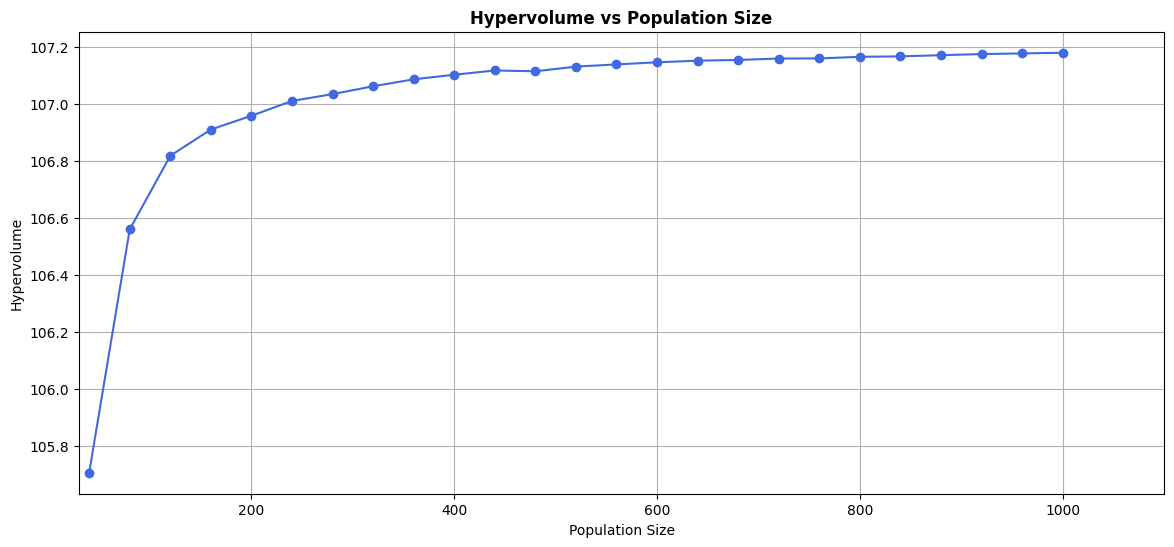

In [71]:
pop_sizes = range(40, 1001, 40)  # From 40 to 1000 with a step of 40
hypervolumes = []

for pop_size in pop_sizes:
    nsga = NSGAII(moo_problem, pop_size=pop_size, n_iter=2000)
    nsga.run()  # Run the algorithm
    hypervolume_value = nsga.calculate_hypervolume()  # Calculate hypervolume
    print(f"Captured Hypervolume Value for pop_size {pop_size}: {hypervolume_value}")
    hypervolumes.append(hypervolume_value)
    
print(hypervolume_value)
    
# Plotting the hypervolume values
plt.figure(figsize=(14, 6))
plt.plot(pop_sizes, hypervolumes, marker='o',color='royalblue')
plt.title('Hypervolume vs Population Size', fontweight='bold')
plt.xlabel('Population Size')
plt.ylabel('Hypervolume')
plt.grid()
plt.xlim(30, 1100)  # Set x limit from 40 to 1000
plt.show()

Num iteration: 1251, Num. function evaluations: 50040
Hypervolume (HV): 105.61750209606629
Num iteration: 626, Num. function evaluations: 50080
Hypervolume (HV): 106.54304518189322
Num iteration: 417, Num. function evaluations: 50040
Hypervolume (HV): 106.76365412222381
Num iteration: 313, Num. function evaluations: 50080
Hypervolume (HV): 106.89314544818447
Num iteration: 251, Num. function evaluations: 50200
Hypervolume (HV): 106.97329942894557
Num iteration: 209, Num. function evaluations: 50160
Hypervolume (HV): 107.00567394045609
Num iteration: 179, Num. function evaluations: 50120
Hypervolume (HV): 107.0433612732949
Num iteration: 157, Num. function evaluations: 50240
Hypervolume (HV): 107.0760162600439
Num iteration: 139, Num. function evaluations: 50040
Hypervolume (HV): 107.09674516480897
Num iteration: 126, Num. function evaluations: 50400
Hypervolume (HV): 107.10043203003636
Num iteration: 114, Num. function evaluations: 50160
Hypervolume (HV): 107.11578008419333
Num iterati

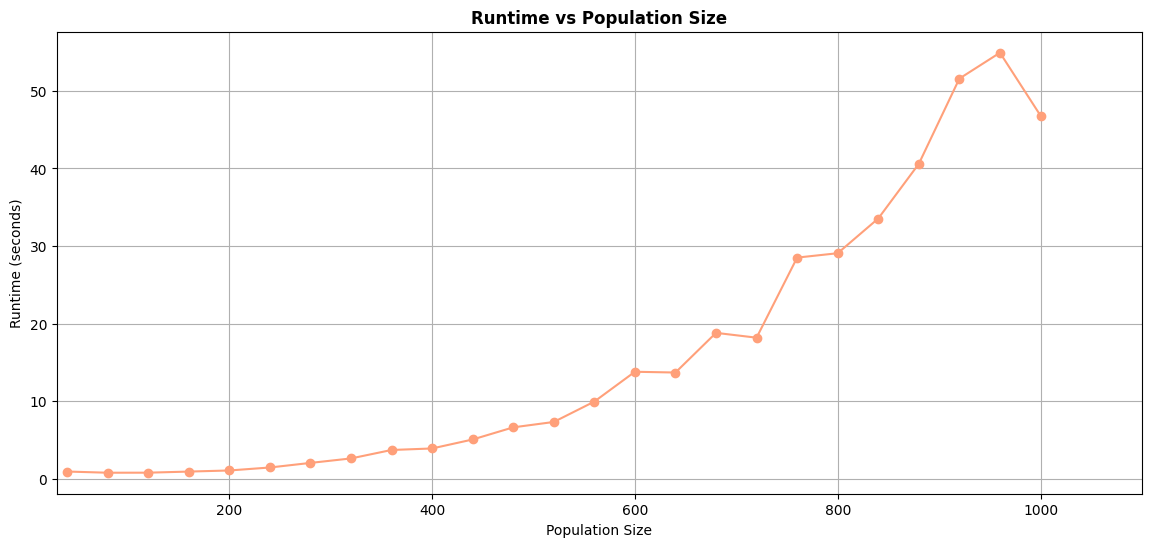

In [72]:
pop_sizes = range(40, 1001, 40)  # From 40 to 1000 with a step of 40
runtimes = []  # List to store runtime values

# Simulate the NSGA-II runs and hypervolume calculations
for pop_size in pop_sizes:
    nsga = NSGAII(moo_problem, pop_size=pop_size, n_iter=2000)
    
    start_time = time.time()  # Start time measurement
    nsga.run()  # Run the algorithm
    hypervolume_value = nsga.calculate_hypervolume()  # Calculate hypervolume
    end_time = time.time()  # End time measurement
    
    runtime = end_time - start_time  # Calculate runtime
    runtimes.append(runtime)  # Store the runtime

print(runtimes)

# Plotting the runtime values
plt.figure(figsize=(14, 6))
plt.plot(pop_sizes, runtimes, marker='o', color='lightsalmon')

plt.title('Runtime vs Population Size', fontweight='bold')
plt.xlabel('Population Size')
plt.ylabel('Runtime (seconds)')
plt.grid()
plt.xlim(30, 1100)  # Set x limit from 40 to 1000
plt.show()

Num iteration: 126, Num. function evaluations: 50400
Non-Dominated Solutions:
Index f1         f2         x         
0     6253.9121  0.0265     3.4557    
1     11403.2870 0.0076     1.0486    
2     11223.7847 0.0077     1.0686    
3     10443.3363 0.0085     1.1664    
4     10324.7659 0.0086     1.1831    
5     11424.6540 0.0075     1.0462    
6     11088.5606 0.0078     1.0842    
7     11478.9486 0.0075     1.0404    
8     11358.5444 0.0076     1.0535    
9     11124.9018 0.0078     1.0799    
10    11738.1340 0.0073     1.0134    
11    10690.7142 0.0082     1.1333    
12    9893.9402  0.0091     1.2484    
13    10792.7768 0.0081     1.1202    
14    10552.8151 0.0083     1.1515    
15    9714.9354  0.0093     1.2781    
16    11612.8962 0.0074     1.0262    
17    11064.1746 0.0079     1.0871    
18    7981.0110  0.0125     1.6889    
19    9056.4060  0.0103     1.4032    
20    7815.9384  0.0129     1.7470    
21    8493.0098  0.0113     1.5364    
22    9689.9471  0.0093  

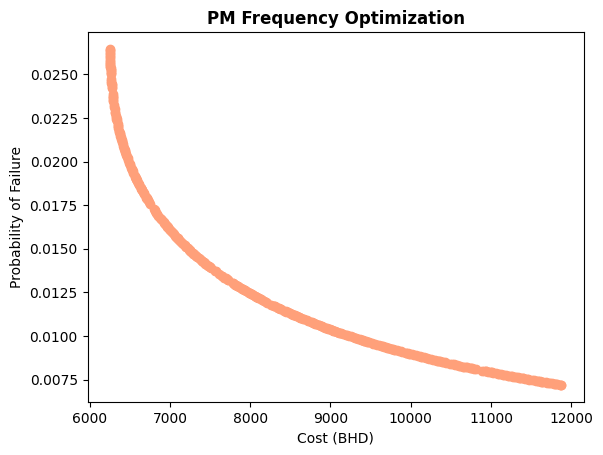

Hypervolume (HV): 107.09654755427536


In [4]:
#First function to optimize
def function1(x):
    value = ((12 / x) * (9.485 * 97)) + ((1 - np.exp(-(x / 105.51) ** 1.0585)) * 97 *1191.896)
    return value

    
#Second function to optimize
def function2(x):
    value = 1-(np.exp(-(x / 105.51) ** 1.0585))
    return value

lb = np.array([[1]])  # Lower bound x
ub = np.array([[12]])  # Upper bound x

moo_problem = MOO_Problem(function1, function2, d=1,lower=lb,upper=ub)
nsgaii = NSGAII(moo_problem, pop_size=400, n_iter=2000)
plt.title('PM Frequency Optimization', fontweight='bold')
plt.xlabel('Cost (BHD)')
plt.ylabel('Probability of Failure')
nsgaii.visualize()

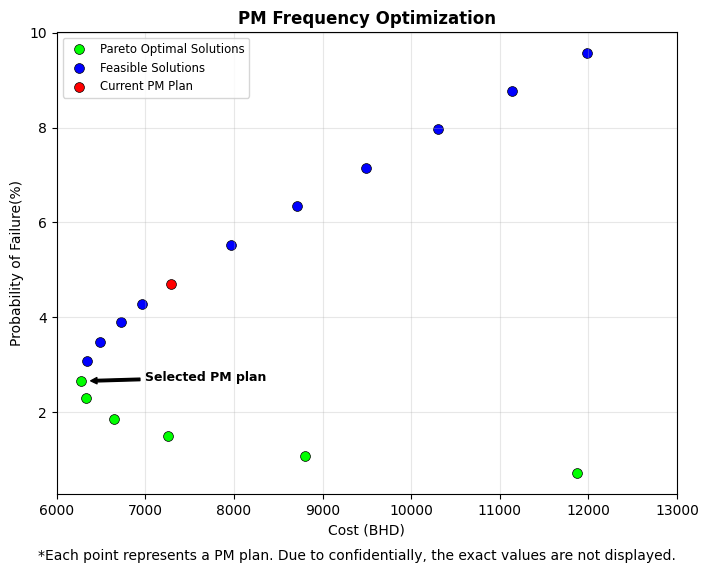

In [28]:
cost_nds = [
    11875.96,
    8805.10,
    7252.39,
    6640.13,
    6329.73,
    6266.48,

]
F_nds = [
0.72, 1.08, 1.50, 1.86,2.29,2.66


]
cost_feasible = [   
    6337.97,
    6482.64,
    6720.27,
    6965.37,    
    7965.53,
    8706.86,
    9490.76,
    10303.27,
    11135.35,
    11980.91
    ]

F_feasible = [ 
    3.09,
    3.47,
    3.90,
    4.28,
    5.53,
    6.34,
    7.15,
    7.96,
    8.76,
    9.57
    ]

x_PM  = 7289.72
y_PM =4.71


plt.figure(figsize=(8, 6))
plt.scatter(cost_nds, F_nds, color='lime', s=50,label="Pareto Optimal Solutions",edgecolors='black',linewidths=0.5)
plt.scatter(cost_feasible, F_feasible, color='blue', s=50,label="Feasible Solutions",edgecolors='black',linewidths=0.5)
plt.scatter(x_PM,y_PM,s=50,color='red',label="Current PM Plan",edgecolors='black',linewidths=0.5)
plt.title("PM Frequency Optimization", fontweight='bold')
plt.xlabel("Cost (BHD)")
plt.ylabel("Probability of Failure(%)")

# Add grid lines
plt.grid(True, linestyle='-', alpha=0.30)

# Annotate with corresponding Final Time values to the right of the points
"""
annotation_nds= [ 
    '1M', '1M 2W', '2M','2M 2W','3M','3M 2W'
]

annotation_feasible= [
    '4M', '4M 2W', '5M', '5M 2W','7M','8M','9M','10M','11M','12M'
]
for i, txt in enumerate(annotation_nds):
    plt.annotate(txt, (cost_nds[i], F_nds[i]), textcoords="offset points", xytext=(10, -3), ha='left', fontsize=9)

for i, txt in enumerate(annotation_feasible):
    plt.annotate(txt, (cost_feasible[i], F_feasible[i]), textcoords="offset points", xytext=(10, -3), ha='left', fontsize=9)

plt.annotate('6M',xy=(x_PM,y_PM), textcoords="offset points", xytext=(10, -3), ha='left',fontsize=9)
"""
plt.figtext(0.5, -0.0, "*Each point represents a PM plan. Due to confidentially, the exact values are not displayed.", ha='center', fontsize=10)
# Set x and y limits for better data visibility
plt.xlim(6000, 13000)
plt.legend(fontsize='small')

plt.annotate('Selected PM plan',fontweight='bold',xy=(6350, 2.66),xytext=(7000, 2.66),arrowprops=dict(facecolor='black', arrowstyle='simple'),fontsize=9, ha='left')

plt.show()